In [16]:
import matplotlib.pyplot as plt
import tqdm
%matplotlib inline

### Simulation Object

In [52]:
def get_community(airport_idx):
    community_id = communities['community'][airport_idx]
    return communities.reset_index()[communities.reset_index()['community'] == community_id].index.values

def close_airport_pct(threshold_above, metric=populations):
    threshold = metric.quantile(q=threshold_above)[0]
    return (metric > threshold).values.reshape(-1)

"""MIT License

Copyright (c) [2020] [Hugo Dolan]

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE."""

import numpy as np
import pandas as pd
import random
from collections import namedtuple

ActionSpace = namedtuple('ActionSpace', ['n','sample'])
ObservationSpace = namedtuple('ObservationSpace', ['n'])

class EpidemicEnvironment:
    def __init__(self, adj_matrix, population_vector, agent_idx, community, infected_idx = 0,
                 alpha_plus = 0.3, alphas_plus = None, c_plus = 0.1,
                 c_minus = 1, beta = 57/160 + 1/7, beta_reduced = 25/160 + 1/7, gamma = 1/16, delta = 1/(2*365), 
                 epsilon = 1/7, centrality = None,p=1, lmbda = 1.2, mu = 0.2, lockdown_threshold = -1):
        """
        SEIRS Network Epidemic Model Environment
        - Currently designed only for a single agent! 
        :param adj_matrix: Adjacency Matrix (A)ij indicates edge from i to j (NxN)
        :param population_vector: Nx1 Vector of populations for each node
        :param agent_idx: Airport index associated with the agent
        :param community: A list of airport indexes of airports in the same community
        :param alpha_plus: Percentage of base population which can fly 
        :param alpha_plus: Percentage of base population which can fly (Specifed as an Nx1 vector)
        :param c_plus: Percentage of flying population who can embark on any day
        :param c_minus: Percentage of flying population who can return on any day
        :param beta: Rate of infection
        :param beta_reduced: Rate of infection for when agent is locked down
        :param gamma: Rate of recovery
        :param delta: Rate of immunity loss
        :param epsilon: Rate at which people move from the exposed to infected stage (syptomatic)
        :param p: base economic penalty for lockdowns or infections
        :param lmbda: rate at which penalty for infections in unmitigated state should be applied > 1
        :param mu: rate at which penalty for infections in lockdown state should be applied < 1
        :param lockdown_threshold: within (0,1) defining pct of population in any node which can get infected before a lockdown
        """
        
        # Initialisation
        self.A = adj_matrix # Adjacency Matrix
        self.A_ones = np.ones_like(self.A) # Array of ones (for efficiency its computed only once)
        self.population_vector = population_vector
        self.N = self.A.shape[0] # Number of airports
        self.ID = np.eye(self.N)
        self.agent_idx = agent_idx
        self.c_plus = c_plus
        self.c_minus = c_minus
        
        if type(alphas_plus) == type(None):
            self.alphas_plus = np.diag(np.repeat(alpha_plus,self.N)) # Airport Vector proportion of populations
        else:
            self.alphas_plus = np.diag(alphas_plus.reshape(-1,)) 

        self.D = self.A.sum(axis=1) # Degrees of airports
        self.D_inv = np.array([1 / deg if deg > 0 else 0 for deg in self.D])
        self.infected_idx = infected_idx
        
        # Differential Equation Matrix
        self.B = np.array([[-1*beta, 0, 0, delta],[beta, -1*epsilon, 0,0],[0,epsilon, -1*gamma, 0],[0, 0, gamma, -1*delta]])
        self.B_reduced = np.array([[-1*beta_reduced, 0, 0, delta],[beta_reduced, -1*epsilon, 0,0],[0,epsilon, -1*gamma, 0],[0, 0, gamma, -1*delta]])
        self.B_zero = np.array([[-1*0, 0, 0, delta],[0, -1*epsilon, 0,0],[0,epsilon, -1*gamma, 0],[0, 0, gamma, -1*delta]])
        
        # Centrality Matrix (N x N)
        # We will refer to it as the 'Diffusion Matrix' 
        # since we use a captial C (like the lower case c_plus/minus for diffusion coeff)
        # Used to weight the distribution of flows on the network
        # So that important airports get more traffic
        
        self.use_centrality = type(centrality) != type(None)
        
        if self.use_centrality:
            C = self.A * centrality.T
            C_norms = np.array([1 / norm if norm > 0 else 0 for norm in C.sum(axis=1)]).reshape((-1,1))
            self.C = C * C_norms # Normalised Centrality 
            
        # Initialise temporal state
        self.reset()
        
        # State And Action Spaces
        # Vector observation space V[0] = Local State, V[1] = Community State, V[2] = Global State
        # With state categores (-1,0,1) = (Decreased Infections, Static, Increased Infections)
        self.observation_space = ObservationSpace(27)
        
        # Either 0 = Open , 1 = Lockdown
        self.action_space = ActionSpace(2, lambda: random.choice([0,1]))
        
        # Reward parameters
        self.lmbda = lmbda
        self.mu = mu
        self.p = p
        
        # State Parameters
        self.community = community
        
        # For simple automatic rules (rather than RL)
        self.lockdown_threshold = lockdown_threshold
        
    def reset(self):
        # For most populations in the network they will start disease free
        s_init, e_init, i_init, r_init = 1, 0, 0, 0

        # Selecting the inital infected population
        i_exposed = 1e-5

        # Population Proportions (s, e, i , r)
        theta_prop_init = np.array([s_init, e_init, i_init, r_init], dtype=np.float64).reshape((-1,1))
        theta_prop_infected = np.array([1 - i_exposed, i_exposed, 0, 0], dtype=np.float64)

        # Compute the population (S,E,I,R) values
        theta_props = np.repeat(theta_prop_init, self.N, axis=1) 
        theta_props[:,self.infected_idx] = theta_prop_infected

        self.thetas_B = theta_props * self.population_vector.T # Dimension 3 x N
        self.thetas_T = np.zeros(self.thetas_B.shape) # Dimension 3 x N - No initial people currently abroad

        self.state_history = []
        self.t = 0
        self.total_population = self.population_vector.sum()
        self.population_vector_flat = self.population_vector.reshape((-1,))
        
        
        # Infection States
        self.last_S_t_global = 0
        self.last_S_t_community = 0
        self.last_S_t_local = 0

        self.set_disabled_airports()

        # Starting State
        return self.state_to_idx(np.array([0, 0, 0]))

    def corrected(self, A,action):
        """
        If a airport is locked down it disables it. WARNING: Currently designed for a single agent only.
        """
        if action == 1:
            mask = np.ones_like(A)
            mask[:,self.agent_idx] = 0
            mask[self.agent_idx,:] = 0
            
            return A * mask
        else:
            return A
   
    def corrected_multiple(self, A, actions):
        agent_idxs = actions == 1

        mask = self.A_ones
        mask[:,agent_idxs] = 0
        mask[agent_idxs,:] = 0
        masked_A = A * mask

        return masked_A
        
    def corrected_degree(self, D, A_corrected, action):
        if action == 1:
            return A_corrected.sum(axis=1)
        else:
            return D
    
    @property
    def stateHistory(self):
        return np.array(self.state_history)
    
    def transform_state(self, current, last):
        if current > last:
            return 1 # Increase
        if current == last:
            return 0 # Static
        else:
            return -1 # Decrease
        
    def state_to_idx(self, state):
        # State[i] has -1,0,1 options
        # We want to simplify by starting with 1-indexing 
        
        idx1 = 2 + state[0]
        idx2 = 2 + state[1]
        idx3 = 2 + state[2]
        
        flattened_idx = idx1 + 3 * (idx2 - 1) + 9 * (idx3 - 1) 
        
        return flattened_idx - 1 # Zero indexed
    
    def set_disabled_airports(self, disable_airports = None):
        # Note we have now depreceated individual actions
        self.disable_airports = disable_airports

        if type(disable_airports) != type(None):
            if self.use_centrality:
                self.C_c = self.corrected_multiple(self.C, disable_airports)
                self.ID_c = self.corrected_degree(self.ID, self.C_c, 1)
            else:
                self.A_c = self.corrected_multiple(self.A, disable_airports) 
                self.D_c = self.corrected_degree(self.D, self.C_c, 1)
        else:
            if self.use_centrality:
                self.C_c = self.C.copy()
                self.ID_c = np.ones((self.ID.shape[0],))
            else:
                self.A_c = self.A.copy()
                self.D_c = self.D.copy()

        row, col = np.diag_indices(self.C_c.shape[0])
        if self.use_centrality:
            self.C_c[row, col] = self.C_c[row, col] - self.ID_c
            self.outer_faster = -1 * self.C_c # ID_c - C_c
        else:
            self.A_c[row, col] = self.A_c[row, col] - self.D_c
            self.outer_faster = -1 * self.A_c # ID_c - C_c     
        
            
    # RK4
    def ODE_solve(self, f_prime, y_0, step_size = 1):
        y = y_0

        # Slightly more complicated again step method
        k1 = step_size * f_prime(y)
        k2 = step_size * f_prime(y + 0.5 * k1)
        k3 = step_size * f_prime(y + 0.5 * k2)
        k4 = step_size * f_prime(y + k3)
        y = y + (1/6) * (k1 + 2*k2 + 2*k3 + k4)

        return y
    
    def step(self, action, disable_travel=False):
        """
        WARNING: Action is no longer implemented
        :param action: 0 = Open; 1 = Lockdown -> leads to beta_reduced being utilised for the agents airport & No travel in or out permitted
        :param disable_travel: Disables all travel 
        :param disable_airports: Disable all travel for selected airports (N Binary Vector)
        :return: (State, Reward)
        """
        # Populations
        thetas = self.thetas_B + self.thetas_T
        thetas_B_populations = self.thetas_B.sum(axis=0)
        thetas_T_populations = self.thetas_T.sum(axis=0)
        thetas_populations = thetas_B_populations + thetas_T_populations
        
         # Epidemic model
        def SIRS_coupled_ode(thetas):
            # Creates the vectors [(S_i * I_i/ M_i, I_i, R_i)^T, ....]
            diff_vector = np.ones((4,self.N))
            diff_vector[0,:] = (thetas[0,:]) * (thetas[2,:]) * (1/thetas.sum(axis=0))  # S
            diff_vector[1,:] = (thetas[1,:])                                           # E
            diff_vector[2,:] = (thetas[2,:])                                           # I
            diff_vector[3,:] = (thetas[3,:])                                           # R

            # Computes differential equation (4x4) @ (4,N) => (4,N)
            d_thetas = self.B @ diff_vector
            
            if self.lockdown_threshold >= 0:
                pct_infections = thetas[2,:] / self.population_vector_flat 
                actions = pct_infections > self.lockdown_threshold
                d_thetas[:, actions] = self.B_reduced @ diff_vector[:, actions].reshape(d_thetas.shape[0],actions.sum())
            elif type(self.disable_airports) != type(None):
                d_thetas[:, self.disable_airports] = self.B_reduced @ diff_vector[:, self.disable_airports].reshape(d_thetas.shape[0],self.disable_airports.sum())
            
            # Doesnt change anything for communities with insufficient cases           
            insignificant_thetas = thetas[1,:] + thetas[2,:] < 100
            d_thetas[:, insignificant_thetas] = self.B_zero @ diff_vector[:, insignificant_thetas]
            
            return d_thetas
        
        # Updating community sizes
        # Community Spread (Immediately before diffusion)
        #thetas_star = thetas + d_thetas # Airport Community States
        thetas_star = self.ODE_solve(SIRS_coupled_ode, thetas)
        
        thetas_B_ratio = thetas_B_populations / thetas_populations
        thetas_T_ratio = thetas_T_populations / thetas_populations

        thetas_B_star = thetas_B_ratio * thetas_star
        thetas_T_star = thetas_T_ratio * thetas_star

        # Travelling populations
        omegas_plus_star = thetas_B_star @ self.alphas_plus # Departures
        omegas_minus_star = thetas_T_star # Arrivals (we got rid of alpha minus as it is redundant)

        # International Spread / Diffusion (1/D prevents simultaneous changes exceeding the supply)
        # Note we did the derivation and it turns out we can replace D with identity and A with C
        # This now successfully weights passenger destinations according to centrality    
        
        if self.use_centrality:
            if self.lockdown_threshold >= 0:
                pct_infections = thetas_star[2,:] / self.population_vector_flat
                actions = pct_infections > self.lockdown_threshold
                row, col = np.diag_indices(self.C_c.shape[0])
                self.C_c = self.corrected_multiple(self.C, actions)
                self.ID_c = self.corrected_degree(self.ID, self.C_c, 1)
                self.C_c[row, col] = self.C_c[row, col] - self.ID_c
                self.outer_faster = -1 * self.C_c
           
            d_omegas_plus = -1 * self.c_plus * ((omegas_plus_star * self.D_inv) @ self.outer_faster) 

            if self.t % 5 == 0:
                # Faster implementation:
                d_omegas_minus = -1 * self.c_minus * ((omegas_minus_star * self.D_inv) @ (self.outer_faster))
                # d_omegas_minus = -1 * self.c_minus * ((omegas_minus_star * self.D_inv) @ (ID_c - C_c))
            else:
                d_omegas_minus = np.zeros(omegas_minus_star.shape)

            if self.lockdown_threshold >= 0:
                pct_infections = thetas_star[2,:] / self.population_vector_flat
                actions = pct_infections > self.lockdown_threshold

        else:
            if self.lockdown_threshold >= 0:
                pct_infections = thetas_star[2,:] / self.population_vector_flat
                actions = pct_infections > self.lockdown_threshold
                row, col = np.diag_indices(self.C_c.shape[0])
                self.A_c = self.corrected_multiple(self.A, actions)
                self.D_c = self.corrected_degree(self.D, self.A_c, 1)
                self.A_c[row, col] = self.A_c[row, col] - self.D_c
                self.outer_faster = -1 * self.A_c # ID_c - C_c

            d_omegas_plus = -1 * self.c_plus * ((omegas_plus_star * self.D_inv) @ (self.outer_faster))

            if self.t % 5 == 0:
                d_omegas_minus = -1 * self.c_minus * ((omegas_minus_star * self.D_inv) @ (self.outer_faster))
            else:
                d_omegas_minus = np.zeros(omegas_minus_star.shape)
                
        # Net change in Community States 
        if disable_travel:
            self.thetas_B = thetas_B_star
            self.thetas_T = thetas_T_star
        else:
            self.thetas_B = thetas_B_star + np.minimum(d_omegas_plus,0) + np.maximum(d_omegas_minus,0) # Base population recieves returning travellers
            self.thetas_T = thetas_T_star + np.maximum(d_omegas_plus,0) + np.minimum(d_omegas_minus,0) # Transient population recieves travellers who have left their home country

        # Record state
        thetas = self.thetas_B + self.thetas_T
        thetas_populations = thetas.sum(axis=0)
        self.state_history.append(thetas)
        self.t += 1
        
        # Compute The State and Reward from last action for the agent
        S_t = thetas[2,self.agent_idx] # Number infected
        M_j = thetas_populations[self.agent_idx] # Current Population we will assume transient individuals count
        
        reward_unmitigated = S_t * self.lmbda * self.p / M_j
        reward_lockdown = (S_t * self.mu * self.p / M_j) + self.p
        reward = - 1 * (reward_unmitigated * (1 - action) + reward_lockdown * action)
        
        # Agent State
        S_t_local = S_t
        discrete_state_local = self.transform_state(S_t_local, self.last_S_t_local)
        
        # Community State
        S_t_community = thetas[2,self.community].sum()
        discrete_state_community = self.transform_state(S_t_community, self.last_S_t_community)
        
        # Global State
        S_t_global = thetas[2,:].sum()
        discrete_state_global = self.transform_state(S_t_global, self.last_S_t_global)
        
        self.last_S_t_local = S_t_local
        self.last_S_t_community = S_t_community
        self.last_S_t_global = S_t_global
        current_state = self.state_to_idx(np.array([discrete_state_local, discrete_state_community, discrete_state_global]))
        
        return current_state, reward

### Simulation Data

In [10]:
adj_matrix = pd.read_csv('./outputs/airport_routes_matrix.csv',index_col=0)
alphas = pd.read_csv('./outputs/airport_alphas.csv', index_col=0)
centralities = pd.read_csv('./outputs/airport_centralities.csv', index_col=0)
populations = pd.read_csv('./outputs/airport_populations.csv', index_col=0)
communities = pd.read_csv('./outputs/bsm_communities.csv', index_col=0).set_index('IATA').reindex(adj_matrix.columns)
airports = pd.read_csv('./outputs/airports_w_populations.csv',index_col=0)
airport_country = pd.read_csv('./outputs/airport_country_mapping.csv', index_col=0).set_index('IATA').reindex(adj_matrix.columns)
betweeness = pd.read_csv('./outputs/airport_betweeness.csv', index_col=0).reindex(adj_matrix.columns)

In [11]:
vals = lambda X: X.values

def get_community(airport_idx):
    community_id = communities['community'][airport_idx]
    return communities.reset_index()[communities.reset_index()['community'] == community_id].index.values

LHR = 147 # London Heathrow
ATL = 2880 # Atlanta
DXB = 3199 # Dubai
WUH = 724 # Wuhan Airport

### Run Simulation

In [30]:
# Params
n_iters = 500
n_days = 10 # until we close some airports

gamma = 1/16
beta = 5 * gamma
eps = 2 * gamma
 

# Initiate Environment
env = EpidemicEnvironment(vals(adj_matrix), vals(populations), ATL, get_community(ATL), infected_idx = WUH, alphas_plus = vals(alphas)
                                  , lmbda = 10, mu = 0.2, centrality=centralities.values, gamma = gamma, beta = beta, epsilon = eps, beta_reduced = beta)

# Always call to be sure
env.reset()

# Run Simulation
for i in range(n_days):
    env.step(0)

# For now don't disable any of the airports (but obviously this can be changed by putting 1 in desired indices)
to_disable = np.zeros((adj_matrix.shape[0],), dtype=np.bool)
env.set_disabled_airports(to_disable)

# Run for the remaining days in simulation
for i in range(n_iters - n_days):
    env.step(0)

print("Done!")

Done!


### Diagnostics

In [24]:
# Results shape is (n_iters, 4 (S,E,I,R), n_airports)
env.stateHistory.shape 

(500, 4, 3272)

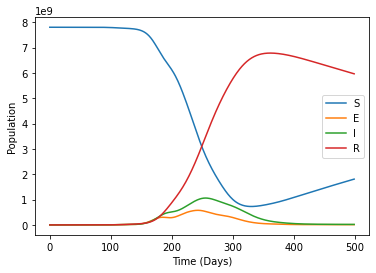

In [31]:
# Visualising global states
global_compartments_over_time = env.stateHistory.sum(axis=2)
plt.plot(global_compartments_over_time)
plt.legend(['S','E','I','R'])
plt.xlabel('Time (Days)')
plt.ylabel('Population')
plt.show()

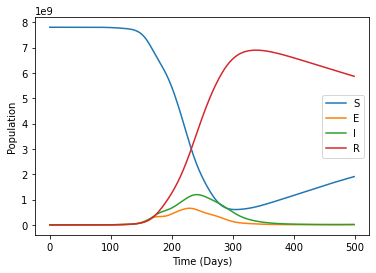

In [6]:
# Visualising global states
global_compartments_over_time = env.stateHistory.sum(axis=2)
plt.plot(global_compartments_over_time)
plt.legend(['S','E','I','R'])
plt.xlabel('Time (Days)')
plt.ylabel('Population')
plt.show()

### Close All After N Days

In [34]:
countries = airport_country['country_IATA'].unique()
dimension = len(airport_country['country_IATA'].unique())

def fitness_function_gen_analysis(n_days):
    def fitness_function(X):
        # 1. Compute the peak infections and total recoveries
        gamma = 1/16
        beta = 5 * gamma # We make this really high to reduce the number of iterations required.
        eps = 2 * gamma
        n_iters = 500
        country_to_disable = np.array(X, dtype=np.bool_)

        mapping = airport_country.reset_index()
        mapping.columns = ['IATA', 'country_IATA']

        # Airports
        to_disable = mapping['country_IATA'].isin(list(countries[country_to_disable])).values

        # As calculated during previous simulation
        max_peak_infections = 3650022879.182167
        max_total_infections = 7213772122.932707

        env = EpidemicEnvironment(vals(adj_matrix), vals(populations), ATL, get_community(ATL), infected_idx = WUH, alphas_plus = vals(alphas)
                                  , lmbda = 10, mu = 0.2, centrality=centralities.values, gamma = gamma, beta = beta, epsilon = eps, beta_reduced = beta)

        env.reset()

        for i in range(n_days):
            env.step(0)

        env.set_disabled_airports(to_disable)

        for i in range(n_iters - n_days):
            env.step(0)

        infections = env.stateHistory[:,2,:].sum(axis=1)
        recoveries = env.stateHistory[:,3,:].sum(axis=1)
        population = env.stateHistory[0,:,:].sum()

        peak_infections = infections.max()
        total_infections = recoveries.max()

        reduced_pct_infections = (1 - (infections.max() / max_peak_infections))
        reduced_pct_recoveries = (1 - (recoveries.max() / max_total_infections)) 
        pct_nodes_enabled = (1 - (to_disable.sum() / to_disable.shape[0])) 

        # Preference towards higher number of nodes
        fitness = reduced_pct_recoveries * reduced_pct_infections * np.sin(0.5 * np.pi * pct_nodes_enabled)
        minimise = 1 - fitness

        return infections.max() / population, recoveries.max() / population, env.stateHistory
    return fitness_function

In [32]:
# All Closed Strategy
results = {}

pbar = tqdm.tqdm(len([1,2,3,4,5,10,25,50,75,100,110,125,150,175,200,300,400,500]))
for days in [1,2,3,4,5,10,25,50,75,100,110,125,150,175,200,300,400,500]:
    pct_peak_infected, pct_total_cases, _ = fitness_function_gen_analysis(days)(np.ones(dimension))
    results[days] = {'peak_infections':pct_peak_infected, 'total_cases':pct_total_cases}
    pbar.update(1)


0it [00:00, ?it/s]
1it [00:12, 12.25s/it]
2it [00:24, 12.31s/it]
3it [00:39, 13.06s/it]
4it [00:54, 13.50s/it]
5it [01:08, 13.72s/it]
6it [01:21, 13.69s/it]
7it [01:36, 13.87s/it]
8it [01:50, 13.89s/it]
9it [02:04, 13.91s/it]
10it [02:17, 13.65s/it]
11it [02:30, 13.58s/it]
12it [02:43, 13.29s/it]
13it [02:55, 12.89s/it]
14it [03:07, 12.81s/it]
15it [03:20, 12.78s/it]
16it [03:34, 13.21s/it]
17it [03:48, 13.53s/it]
18it [04:02, 13.45s/it]

(-1.0, 18.0)

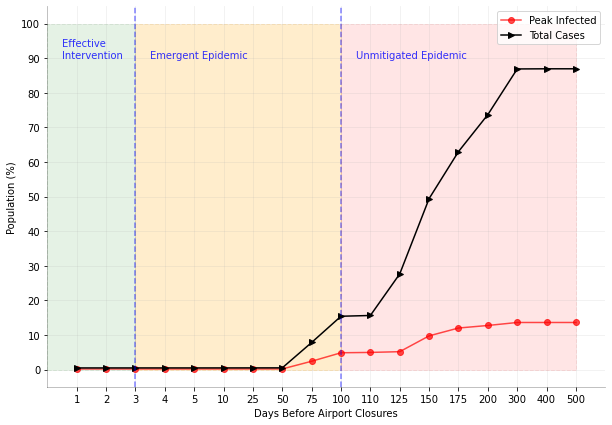

In [33]:
# Plot
n_days = len([1,2,3,4,5,10,25,50,75,100,110,125,150,175,200,300,400,500])

plt.figure(figsize=(10,7))
results_df = pd.DataFrame(results).T
plt.plot(np.arange(0,results_df.shape[0]), results_df['peak_infections'] * 100, marker='o', c='r', alpha=0.7, label='Peak Infected')
plt.plot(np.arange(0,results_df.shape[0]), results_df['total_cases'] * 100, marker='>', c='k', label='Total Cases')
plt.xticks(np.arange(0,results_df.shape[0]),labels=results_df.index)
plt.yticks(np.arange(0,110,10))
plt.xlabel('Days Before Airport Closures')
plt.ylabel('Population (%)')
plt.legend()
plt.grid(alpha=0.2)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color((0,0,0,0.3))
ax.spines['bottom'].set_color((0,0,0,0.3))

plt.axvline(2, c='b', linestyle='--', alpha=0.5)
plt.fill_between(np.arange(2,10,1),100,0, linestyle='--', color='orange',alpha=0.2)
plt.annotate('Emergent Epidemic',(2.5,90), c='b', alpha = 0.8)


plt.axvline(9, c='b', linestyle='--', alpha=0.5)
plt.fill_between(np.arange(9,n_days,1),100,0, linestyle='--', color='r',alpha=0.1)
plt.annotate('Unmitigated Epidemic',(9.5,90), c='b', alpha = 0.8)

plt.annotate('Effective\nIntervention',(-.5,90), c='b', alpha = 0.8)
plt.fill_between(np.arange(-1,3,1),100,0, linestyle='--', color='g',alpha=0.1)

plt.xlim(-1,n_days)

### Sensitivity Analysis

In [48]:
from tqdm import trange

# Airport Examples
k_vals = [1.1, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0]
s_vals = [1.05, 1.25, 1.75, 2.0, 2.5, 3.0]
gamma = 1/16

# selected_IATA = [LHR,DXB,ATL]
IATA_results = {}
stateHistories = np.zeros((len(s_vals),len(k_vals))).tolist()
JFK = 3097
HKG = 1197
LHR = 147 # London Heathrow
ATL = 2880 # Atlanta
DXB = 3199 # Dubai

pbar = tqdm.tqdm(5)

for IATA in [JFK,HKG, DXB, LHR, ATL]:
    IATA_results[IATA] = {
        'idx_first_grt_1000': np.zeros((len(s_vals),len(k_vals))),
        'idx_last_grt_1000': np.zeros((len(s_vals),len(k_vals))),
        'idx_max_I': np.zeros((len(s_vals),len(k_vals))),
        'max_I': np.zeros((len(s_vals),len(k_vals))),
    }
    
    for idx_k, k in enumerate(k_vals):
        for idx_s, s in enumerate(s_vals[:idx_k+1]):

            beta = k * gamma
            epsilon = s * gamma

            env = EpidemicEnvironment(vals(adj_matrix), vals(populations), 0, 0, infected_idx = WUH, alphas_plus = vals(alphas),
                                  lmbda = 10, mu = 0.2, centrality=centralities.values, gamma = gamma, beta = beta, epsilon = epsilon)

            env.reset()

            for i in range(500):
                env.step(0)
            
            sh = env.stateHistory
            stateHistories[idx_s][idx_k] = sh

            idx_first_grt_1000 = (sh[:,2,IATA] > 10000).argmax()
            idx_max_I = sh[:,2,IATA].argmax()

            if len(sh[idx_max_I+1:,2,IATA]) > 0:
                idx_last_grt_1000 = idx_max_I + (sh[idx_max_I+1:,2,IATA] < 10000).argmax()
            else:
                idx_last_grt_1000 = -1

            max_I = sh[:,2,IATA].max()

            IATA_results[IATA]['idx_first_grt_1000'][idx_s,idx_k] = idx_first_grt_1000
            IATA_results[IATA]['idx_max_I'][idx_s,idx_k] = idx_max_I
            IATA_results[IATA]['idx_last_grt_1000'][idx_s,idx_k] = idx_last_grt_1000
            IATA_results[IATA]['max_I'][idx_s,idx_k] = max_I
            
    pbar.update(1)



0it [00:00, ?it/s]

1it [07:08, 428.35s/it]

2it [14:16, 428.40s/it]

3it [21:24, 428.13s/it]

4it [27:52, 416.26s/it]

5it [34:11, 405.01s/it]

In [49]:
content = ""
cats = ['idx_first_grt_1000','idx_max_I','max_I','idx_last_grt_1000']
iata_map = {JFK:'JFK', HKG:'HKG', DXB:'DXB', LHR:'LHR', ATL:'ATL'}

for IATA in [JFK,HKG, DXB, LHR, ATL]:
    print(iata_map[IATA], ":  ---------------")
    for stat in cats:
        print(stat, "|===========")
        for row_idx in range(IATA_results[IATA][stat].shape[0]):

            row = IATA_results[IATA][stat][row_idx,:]
            for col_idx in range(IATA_results[IATA][stat].shape[1]):
                val = row[col_idx]
                if int(val) == 0:
                    content += '-' + "\t"
                elif stat != "max_I" and int(val) >= 499 or int(val) == -1:
                    content += '+' + "\t"
                else:
                    if stat == 'max_I':
                        content += str(round(val / 1e6,2)) + "\t"
                    else:
                        content += str(int(val)) + "\t"
        #             
            content = content[:-1]
            content += "\n"

        print(content)
        content = ""

JFK :  ---------------
idx_first_grt_1000 |===========
-	-	-	400	326	250	208
-	-	+	370	303	231	193
-	-	437	324	264	200	167
-	-	-	307	250	191	159
-	-	-	-	232	176	146
-	-	-	-	-	165	137

idx_max_I |===========
495	495	+	+	485	370	306
-	495	+	+	450	341	285
-	-	+	480	390	296	245
-	-	-	455	370	281	233
-	-	-	-	343	260	215
-	-	-	-	-	243	200

max_I |===========
-	-	0.0	0.61	4.57	4.95	5.09
-	0.0	0.01	2.11	4.68	5.09	5.25
-	-	0.11	4.42	4.86	5.31	5.51
-	-	-	4.47	4.92	5.39	5.6
-	-	-	-	5.0	5.49	5.73
-	-	-	-	-	5.56	5.83

idx_last_grt_1000 |===========
495	495	+	+	485	370	306
-	495	+	+	450	341	285
-	-	+	480	390	296	245
-	-	-	455	370	281	233
-	-	-	-	343	260	215
-	-	-	-	-	243	200

HKG :  ---------------
idx_first_grt_1000 |===========
-	-	375	275	224	169	140
-	-	346	253	206	155	129
-	-	298	218	177	134	110
-	-	-	207	167	126	104
-	-	-	-	154	115	95
-	-	-	-	-	108	89

idx_max_I |===========
495	+	+	+	408	308	254
-	+	+	463	376	283	234
-	-	+	401	324	244	201
-	-	-	381	308	231	191
-	-	-	-	283	212	174
-	-	-	-	-	19

### Single Airport Benchmark

In [50]:
# Single Airport Benchmark (FIX)
k_vals = [1.1, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0]
s_vals = [1.05, 1.25, 1.75, 2.0, 2.5, 3.0]
gamma = 1/16

# selected_IATA = [LHR,DXB,ATL]
IATA_results = {}
stateHistories = np.zeros((len(s_vals),len(k_vals))).tolist()

for IATA in [0]:
    IATA_results[IATA] = {
        'idx_first_grt_1000': np.zeros((len(s_vals),len(k_vals))),
        'idx_last_grt_1000': np.zeros((len(s_vals),len(k_vals))),
        'idx_max_I': np.zeros((len(s_vals),len(k_vals))),
        'max_I': np.zeros((len(s_vals),len(k_vals))),
    }
    
    for idx_k, k in enumerate(k_vals):
        for idx_s, s in enumerate(s_vals[:idx_k+1]):

            beta = k * gamma
            epsilon = s * gamma
                
            adj = np.zeros((1,1))
            pop = np.zeros((1,1))
            pop[0] = populations.sum() / populations.shape[0]
                
            env = EpidemicEnvironment(adj, pop, 0, 0, infected_idx = 0, alphas_plus = np.ones((1,1)),
                                  lmbda = 10, mu = 0.2, centrality= np.ones((1,1)), gamma = gamma, beta = beta, epsilon = epsilon)

            with trange(500) as t:
                env.reset()

                for i in t:
                    env.step(0)
            
            sh = env.stateHistory 
            stateHistories[idx_s][idx_k] = sh

            idx_first_grt_1000 = (sh[:,2,IATA] > 10000).argmax()
            idx_max_I = sh[:,2,IATA].argmax()

            if len(sh[idx_max_I+1:,2,IATA]) > 0:
                idx_last_grt_1000 = idx_max_I + (sh[idx_max_I+1:,2,IATA] < 10000).argmax()
            else:
                idx_last_grt_1000 = -1

            max_I = sh[:,2,IATA].max()

            IATA_results[IATA]['idx_first_grt_1000'][idx_s,idx_k] = idx_first_grt_1000
            IATA_results[IATA]['idx_max_I'][idx_s,idx_k] = idx_max_I
            IATA_results[IATA]['idx_last_grt_1000'][idx_s,idx_k] = idx_last_grt_1000
            IATA_results[IATA]['max_I'][idx_s,idx_k] = max_I
            
            
content = ""
IATA = JFK
cats = ['idx_first_grt_1000','idx_max_I','max_I','idx_last_grt_1000']


for IATA in [0]:
    print(IATA, ":  ---------------")
    for stat in cats:
        print(stat, "|===========")
        for row_idx in range(IATA_results[IATA][stat].shape[0]):

            row = IATA_results[IATA][stat][row_idx,:]
            for col_idx in range(IATA_results[IATA][stat].shape[1]):
                val = row[col_idx]
                if int(val) == 0:
                    content += '-' + "\t"
                elif stat != "max_I" and int(val) >= 499 or int(val) == -1:
                    content += '+' + "\t"
                else:
                    if stat == 'max_I':
                        content += str(round(val / 1e6,2)) + "\t"
                    else:
                        content += str(int(val)) + "\t"
        #             
            content = content[:-1]
            content += "\n"

        print(content)
        content = ""




  0%|          | 0/500 [00:00<?, ?it/s]


 41%|████      | 205/500 [00:00<00:00, 2047.23it/s]


100%|██████████| 500/500 [00:00<00:00, 2156.92it/s]



  0%|          | 0/500 [00:00<?, ?it/s]


100%|██████████| 500/500 [00:00<00:00, 2679.27it/s]



  0%|          | 0/500 [00:00<?, ?it/s]


100%|██████████| 500/500 [00:00<00:00, 2560.37it/s]



  0%|          | 0/500 [00:00<?, ?it/s]


100%|██████████| 500/500 [00:00<00:00, 2766.05it/s]



  0%|          | 0/500 [00:00<?, ?it/s]


100%|██████████| 500/500 [00:00<00:00, 3028.41it/s]



  0%|          | 0/500 [00:00<?, ?it/s]


100%|██████████| 500/500 [00:00<00:00, 2918.93it/s]



  0%|          | 0/500 [00:00<?, ?it/s]


100%|██████████| 500/500 [00:00<00:00, 2909.09it/s]



  0%|          | 0/500 [00:00<?, ?it/s]


100%|██████████| 500/500 [00:00<00:00, 3188.61it/s]



  0%|          | 0/500 [00:00<?, ?it/s]


100%|██████████| 500/500 [00:00<00:00, 3093.43it/s]



  0%|          | 0/500 [00:00<?, ?it/s]


100%|██████████| 500/500 [00

0 :  ---------------
idx_first_grt_1000 |===========
-	-	-	-	-	-	-
-	-	-	-	-	-	-
-	-	-	-	-	-	-
-	-	-	-	-	-	-
-	-	-	-	-	-	-
-	-	-	-	-	-	-

idx_max_I |===========
15	15	15	15	15	15	15
-	13	13	13	13	13	13
-	-	11	11	11	11	11
-	-	-	10	10	10	10
-	-	-	-	9	9	9
-	-	-	-	-	8	8

max_I |===========
0.0	0.0	0.0	0.0	0.0	0.0	0.0
-	0.0	0.0	0.0	0.0	0.0	0.0
-	-	0.0	0.0	0.0	0.0	0.0
-	-	-	0.0	0.0	0.0	0.0
-	-	-	-	0.0	0.0	0.0
-	-	-	-	-	0.0	0.0

idx_last_grt_1000 |===========
15	15	15	15	15	15	15
-	13	13	13	13	13	13
-	-	11	11	11	11	11
-	-	-	10	10	10	10
-	-	-	-	9	9	9
-	-	-	-	-	8	8



### Close After N Days relative reductions

In [53]:
for multiplier in [3,5]:
    print("Multiplier: ", multiplier)
    # After N Days Close everything
    disable_travel_after = [1,2,3,4,5,500]
    # disable_travel_after = [500]
    # disable_travel_after = [5,10,15,25,50,75,100,500]
    disable_experiments_high_inf = {}

    n_iters = 1000

    gamma = 1/16
    beta = multiplier * gamma
    eps = 2 * gamma

    env = EpidemicEnvironment(vals(adj_matrix), vals(populations), ATL, get_community(ATL), infected_idx = WUH, alphas_plus = vals(alphas)
                              , lmbda = 10, mu = 0.2, centrality=centralities.values, gamma = gamma, beta = beta, beta_reduced = beta, epsilon = eps)


    for disable_timestep in disable_travel_after:
        print(disable_timestep)
        env.reset()

        for i in range(disable_timestep):
            env.step(0)

        to_disable = close_airport_pct(0)
        env.set_disabled_airports(to_disable)

        for i in range(n_iters - disable_timestep):
            env.step(0)

        disable_experiments_high_inf[disable_timestep] = env.stateHistory

    experiments = disable_experiments_high_inf

    # Diagnostic
    total_population = experiments[500][0,:,:].sum()

    infections_500 = experiments[500][:,2,:].sum(axis=1)
    recoveries_500 = experiments[500][:,3,:].sum(axis=1)

    for key in disable_travel_after:
        infections = experiments[key][:,2,:].sum(axis=1)
        recoveries = experiments[key][:,3,:].sum(axis=1)
        reduced_pct_infections = (1 - (infections.max() / infections_500.max())) * 100
        reduced_pct_recoveries = (1 - (recoveries.max() / recoveries_500.max())) * 100

        print(key)
        print("Pct Reduction in INFECTIONS (on 500 case): %s" % round(reduced_pct_infections,2))
        print("Pct Reduction in Recoveries (on 500 case): %s" % round(reduced_pct_recoveries,2))
        

Multiplier:  3
1
2
3
4
5
500
1
Pct Reduction in INFECTIONS (on 500 case): 98.89
Pct Reduction in Recoveries (on 500 case): 99.46
2
Pct Reduction in INFECTIONS (on 500 case): 98.89
Pct Reduction in Recoveries (on 500 case): 99.46
3
Pct Reduction in INFECTIONS (on 500 case): 98.89
Pct Reduction in Recoveries (on 500 case): 99.46
4
Pct Reduction in INFECTIONS (on 500 case): 98.89
Pct Reduction in Recoveries (on 500 case): 99.46
5
Pct Reduction in INFECTIONS (on 500 case): 98.88
Pct Reduction in Recoveries (on 500 case): 99.45
500
Pct Reduction in INFECTIONS (on 500 case): 0.0
Pct Reduction in Recoveries (on 500 case): 0.0
Multiplier:  5
1
2
3
4
5
500
1
Pct Reduction in INFECTIONS (on 500 case): 98.89
Pct Reduction in Recoveries (on 500 case): 99.48
2
Pct Reduction in INFECTIONS (on 500 case): 98.89
Pct Reduction in Recoveries (on 500 case): 99.48
3
Pct Reduction in INFECTIONS (on 500 case): 98.89
Pct Reduction in Recoveries (on 500 case): 99.48
4
Pct Reduction in INFECTIONS (on 500 case):

### Threshold Rule

In [58]:

for multiplier in [3,5]:
    print("Multiplier: ", multiplier)
    
    # Threshold Rule
    threshold_infections_after = [1e-7,1e-6,1e-5,1e-3,1e-2,-1]
    pct_disable_experiments_high_inf = {}

    gamma = 1/16
    beta = multiplier * gamma
    eps = 2 * gamma

    for threshold in threshold_infections_after:

        env = EpidemicEnvironment(vals(adj_matrix), vals(populations), ATL, get_community(ATL), infected_idx = WUH, alphas_plus = vals(alphas)
                              , lmbda = 10, mu = 0.2, centrality=centralities.values, gamma = gamma, beta = beta, epsilon = eps, beta_reduced = beta
                                 , lockdown_threshold = -1)

        env.reset()

        
        for i in range(500):
            env.step(0)

            # Ensures the first day is not affected
            env.lockdown_threshold = threshold


        pct_disable_experiments_high_inf[threshold] = env.stateHistory


    experiments = pct_disable_experiments_high_inf

    total_population = experiments[-1][0,:,:].sum()

    infections_500 = experiments[-1][:,2,:].sum(axis=1)
    recoveries_500 = experiments[-1][:,3,:].sum(axis=1)

    infections_data = []
    recoveries_data = []

    for key in threshold_infections_after:
        infections = experiments[key][:,2,:].sum(axis=1)
        recoveries = experiments[key][:,3,:].sum(axis=1)
        reduced_pct_infections = (1 - (infections.max() / infections_500.max())) * 100
        reduced_pct_recoveries = (1 - (recoveries.max() / recoveries_500.max())) * 100

        infections_data.append(reduced_pct_infections)
        recoveries_data.append(reduced_pct_recoveries)

        print(key)
        print("Pct Reduction in INFECTIONS (on 500 case): %s" % round(reduced_pct_infections,2))
        print("Pct Reduction in Recoveries (on 500 case): %s" % round(reduced_pct_recoveries,2))

Multiplier:  3
1e-07
Pct Reduction in INFECTIONS (on 500 case): 98.89
Pct Reduction in Recoveries (on 500 case): 99.45
1e-06
Pct Reduction in INFECTIONS (on 500 case): 98.89
Pct Reduction in Recoveries (on 500 case): 99.45
1e-05
Pct Reduction in INFECTIONS (on 500 case): 98.87
Pct Reduction in Recoveries (on 500 case): 99.43
0.001
Pct Reduction in INFECTIONS (on 500 case): 98.83
Pct Reduction in Recoveries (on 500 case): 99.41
0.01
Pct Reduction in INFECTIONS (on 500 case): 29.42
Pct Reduction in Recoveries (on 500 case): 35.99
-1
Pct Reduction in INFECTIONS (on 500 case): 0.0
Pct Reduction in Recoveries (on 500 case): 0.0
Multiplier:  5
1e-07
Pct Reduction in INFECTIONS (on 500 case): 98.89
Pct Reduction in Recoveries (on 500 case): 99.48
1e-06
Pct Reduction in INFECTIONS (on 500 case): 98.89
Pct Reduction in Recoveries (on 500 case): 99.48
1e-05
Pct Reduction in INFECTIONS (on 500 case): 98.87
Pct Reduction in Recoveries (on 500 case): 99.47
0.001
Pct Reduction in INFECTIONS (on 500 

In [57]:
for metric_name, metric in {'populations':populations, 'centrality':centralities, 'betweeness':betweeness}.items():
    print('Metric: ', metric_name)
    table_inf = []
    table_rec = []

    for fraction_to_disable in [0.01,0.05,0.1,0.25,1]:
        # Close a fraction of aiports after N Days
        disable_fraction_experiments = {}
        disable_after_n_days = [1,2,3,4,5,500]

        n_iters = 500

        gamma = 1/16
        beta = 5 * gamma
        eps = 2 * gamma

        env = EpidemicEnvironment(vals(adj_matrix), vals(populations), ATL, get_community(ATL), infected_idx = WUH, alphas_plus = vals(alphas)
                                  , lmbda = 10, mu = 0.2, centrality=centralities.values, gamma = gamma, beta = beta, epsilon = eps, beta_reduced = beta)

        for n_days in disable_after_n_days:
            env.reset()

            for i in range(n_days):
                env.step(0)
                pbar.update(1)

            to_disable = close_airport_pct(1 - fraction_to_disable, metric) if n_days != 500 else close_airport_pct(0, metric)
            env.set_disabled_airports(to_disable)

            for i in range(n_iters - n_days):
                env.step(0)
                pbar.update(1)

            disable_fraction_experiments[n_days] = env.stateHistory

        experiments = disable_fraction_experiments

        total_population = experiments[500][0,:,:].sum()

        infections_500 = experiments[500][:,2,:].sum(axis=1)
        recoveries_500 = experiments[500][:,3,:].sum(axis=1)

        infections_data = []
        recoveries_data = []

        row_rec = []
        row_inf = []

        for key in disable_after_n_days:
            infections = experiments[key][:,2,:].sum(axis=1)
            recoveries = experiments[key][:,3,:].sum(axis=1)
        #     print(infections.max(), infections_500.max())
            reduced_pct_infections = (1 - (infections.max() / infections_500.max())) * 100
            reduced_pct_recoveries = (1 - (recoveries.max() / recoveries_500.max())) * 100

            infections_data.append(reduced_pct_infections)
            recoveries_data.append(reduced_pct_recoveries)

        #     print(key)
        #     print("Pct Reduction in INFECTIONS (on 500 case): %s" % round(reduced_pct_infections,2))
        #     print("Pct Reduction in Recoveries (on 500 case): %s" % round(reduced_pct_recoveries,2))
            row_inf.append(str(round(reduced_pct_infections,2)))
            row_rec.append(str(round(reduced_pct_recoveries,2)))


        table_inf.append('\t'.join(row_inf[:-1]))
        table_rec.append('\t'.join(row_rec[:-1]))

    print('\n'.join(table_inf))
    print('\n')
    print('\n'.join(table_rec))

Metric:  populations
98.89	98.89	98.89	98.88	98.88
98.89	98.89	98.89	98.88	98.88
98.89	98.89	98.89	98.88	98.88
98.89	98.89	98.89	98.88	98.88
98.89	98.89	98.89	98.88	98.88


99.48	99.48	99.48	99.47	99.47
99.48	99.48	99.48	99.47	99.47
99.48	99.48	99.48	99.47	99.47
99.48	99.48	99.48	99.47	99.47
99.48	99.48	99.48	99.47	99.47
Metric:  centrality
26.78	26.81	26.89	26.92	26.96
98.89	98.89	98.89	98.88	98.88
98.89	98.89	98.89	98.88	98.88
98.89	98.89	98.89	98.88	98.88
98.89	98.89	98.89	98.88	98.88


8.71	8.76	8.82	8.87	8.93
99.48	99.48	99.48	99.47	99.47
99.48	99.48	99.48	99.47	99.47
99.48	99.48	99.48	99.47	99.47
99.48	99.48	99.48	99.47	99.47
Metric:  betweeness
25.73	25.76	25.79	25.83	25.87
66.42	66.45	66.48	66.51	66.55
98.89	98.89	98.89	98.88	98.88
98.89	98.89	98.89	98.88	98.88
98.89	98.89	98.89	98.88	98.88


9.33	9.38	9.43	9.49	9.54
54.88	54.97	55.05	55.13	55.21
99.48	99.48	99.48	99.47	99.47
99.48	99.48	99.48	99.47	99.47
99.48	99.48	99.48	99.47	99.47
